In [ ]:
# wget.download("http://data.celltrackingchallenge.net/training-datasets/Fluo-N2DL-HeLa.zip")

In [3]:
# stardist / tensorflow env variables setup
import os
os.environ["OMP_NUM_THREADS"] = "4"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from pathlib import Path

import napari
import numpy as np
from napari.utils.notebook_display import nbscreenshot
from tqdm import tqdm
from rich.pretty import pprint

from stardist.models import StarDist3D

from ultrack import segment, link, solve, to_tracks_layer, tracks_to_zarr
from ultrack.utils import estimate_parameters_from_labels, labels_to_edges
from ultrack.config import MainConfig

In [4]:
def normalize(arr: np.ndarray) -> np.ndarray:
    """Normalizes an array to values between (0, 1)"""
    arr = np.asarray(arr)
    arr = np.sqrt(arr)
    arr = arr - np.quantile(arr, 0.001)
    arr = arr / np.quantile(arr, 0.999)
    arr = np.clip(arr, 0, 1)
    return arr

def predict(image: np.ndarray, model: StarDist3D) -> np.ndarray:
    """Normalizes the image per frame and computes stardist prediction"""
    labels = np.zeros_like(image, dtype=np.int32)
    for t in tqdm(range(labels.shape[0]), "Predicting labels"):
        frame = normalize(image[t])
        labels[t], _ = model.predict_instances_big(
            frame, "YX", block_size=560, min_overlap=96, show_progress=False,
        )
    return labels

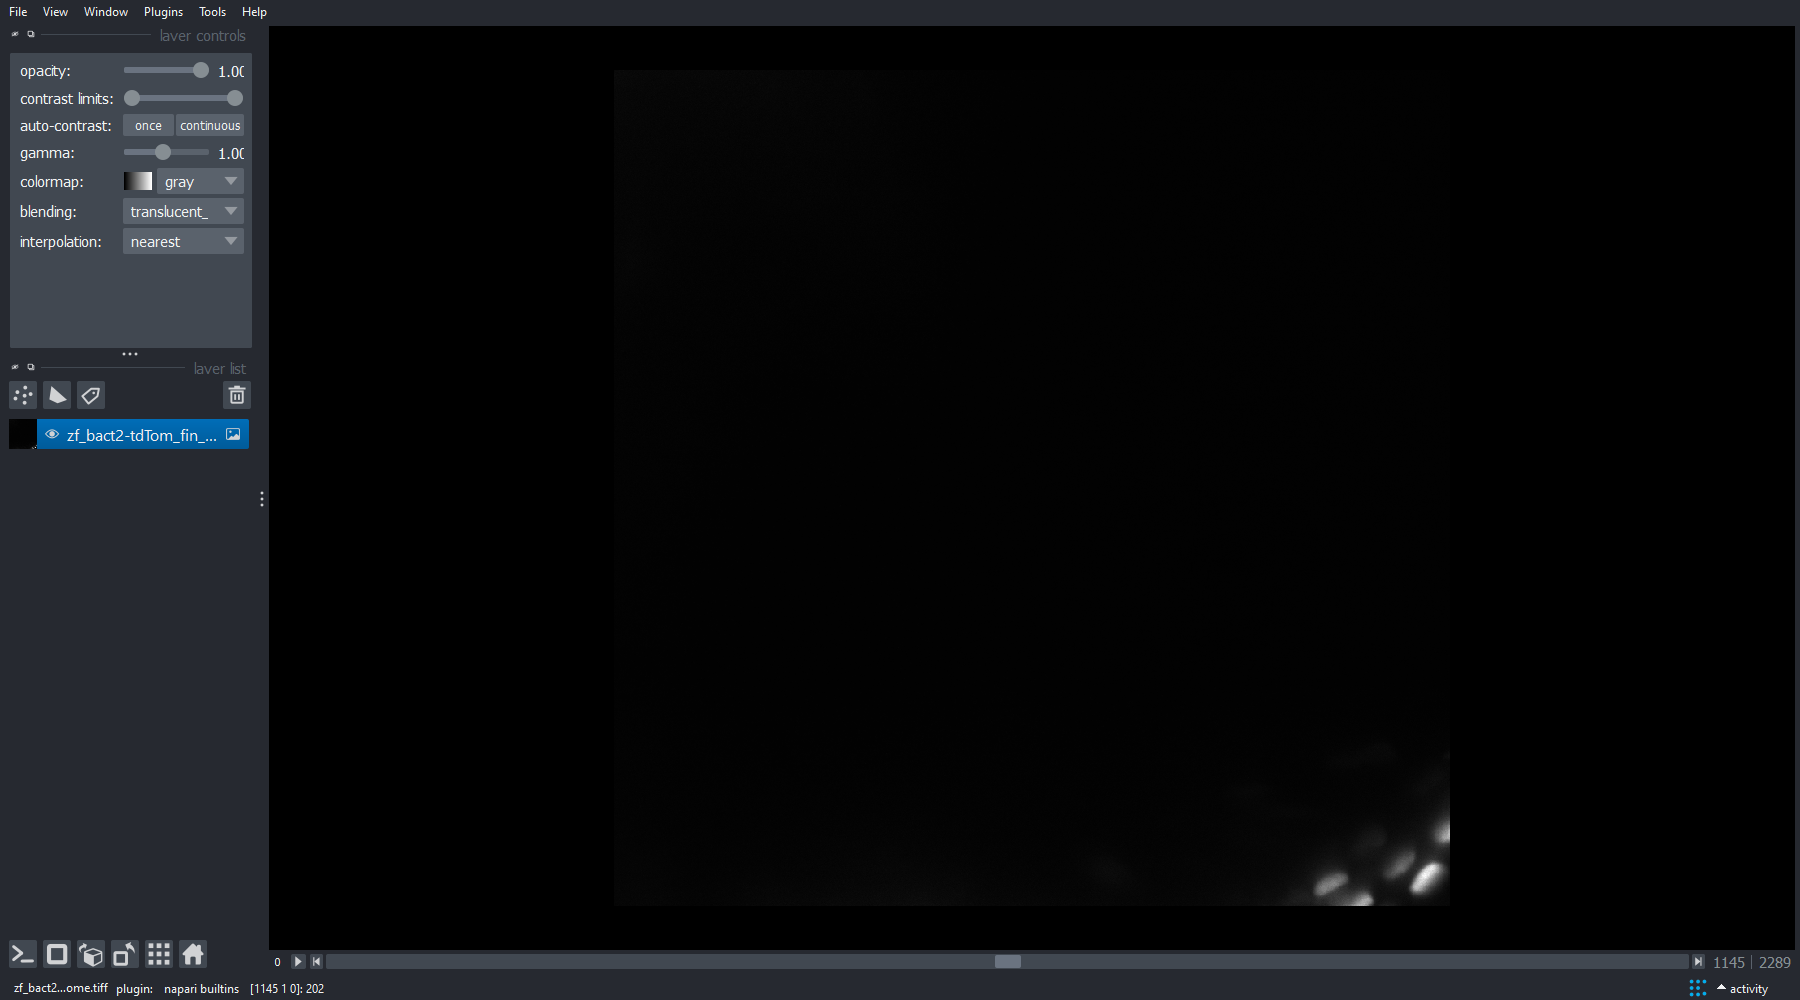

In [16]:
dataset_path = Path("D:\\Nick\\20230525\\processed_data\\")

viewer = napari.Viewer()
viewer.window.resize(1800, 1000)
viewer.open(sorted(dataset_path.glob("*_short.ome.tiff")), stack=True)

nbscreenshot(viewer)

In [14]:
%%capture
model = StarDist3D.from_pretrained("3D_demo")
stardist_labels = predict(viewer.layers[0].data, model)

viewer.add_labels(stardist_labels, name="stardist")

KeyError: 'Z'

In [15]:
viewer.layers[0].data.shape

(2290, 1028, 1028)

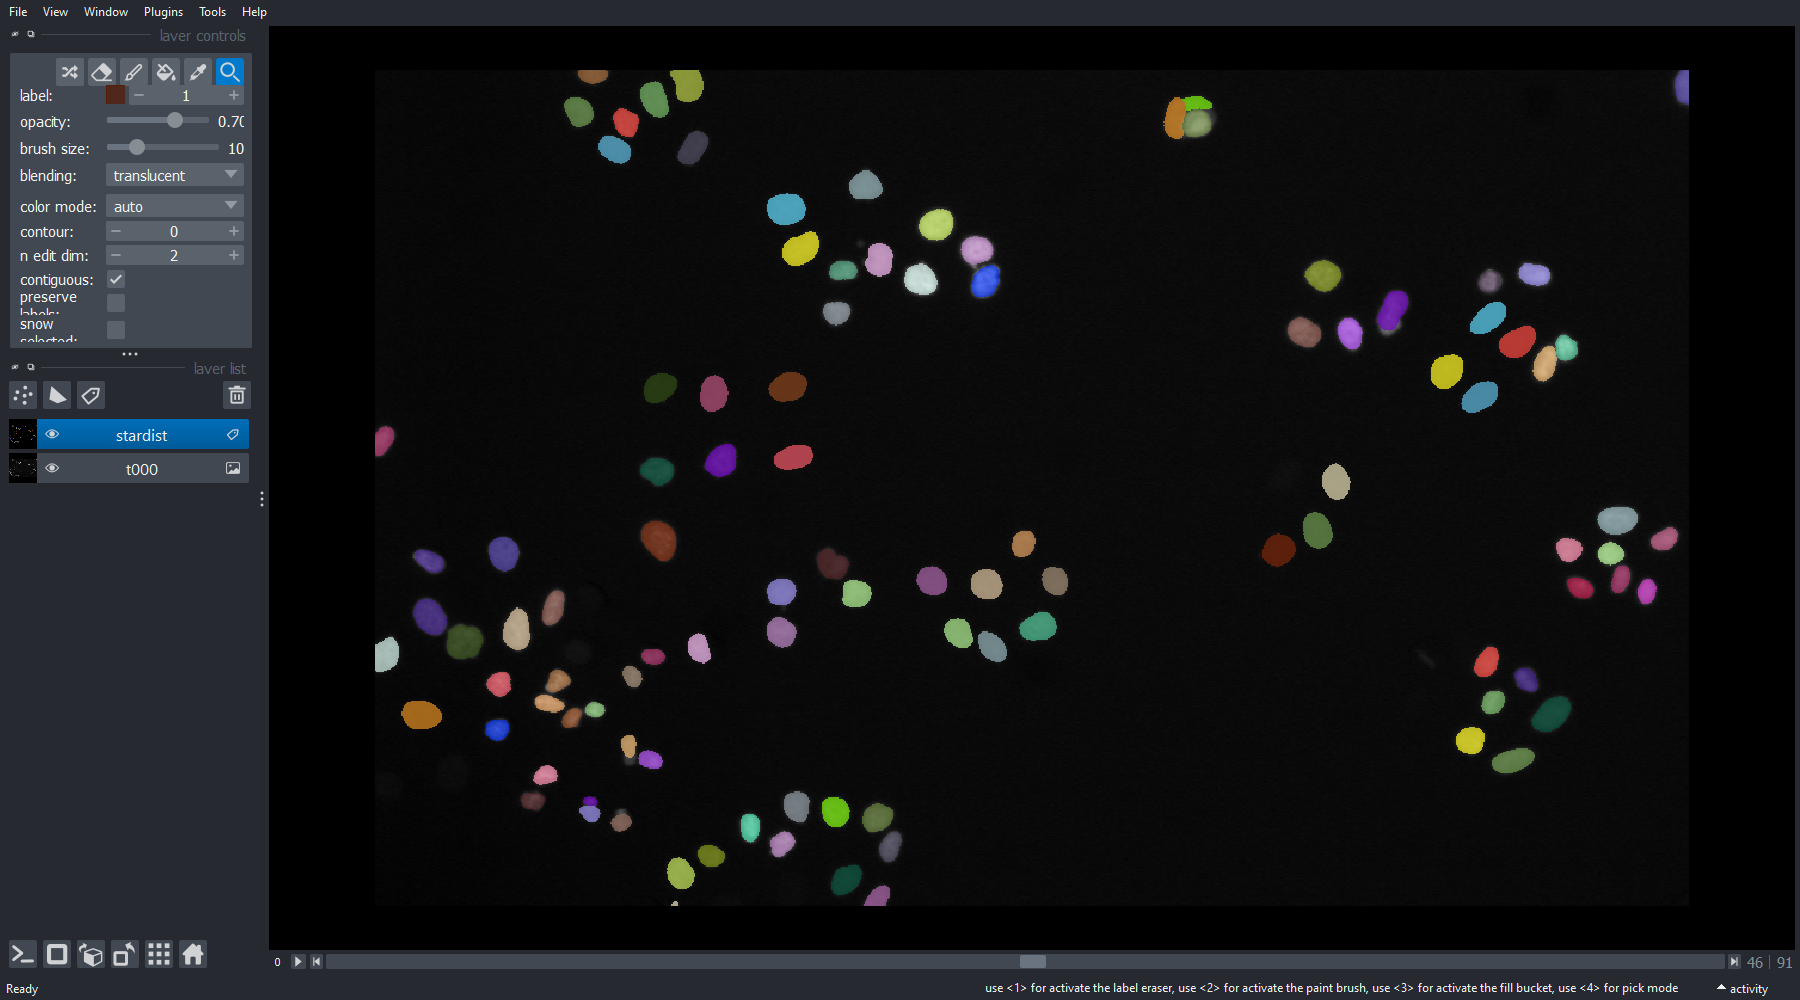

In [20]:
nbscreenshot(viewer)

## Tracking

In [21]:
detection, edges = labels_to_edges(stardist_labels, sigma=4.0)  # multiple labels can be used with [labels_0, labels_1, ...]

Converting labels to edges: 100%|██████████| 92/92 [00:05<00:00, 16.91it/s]


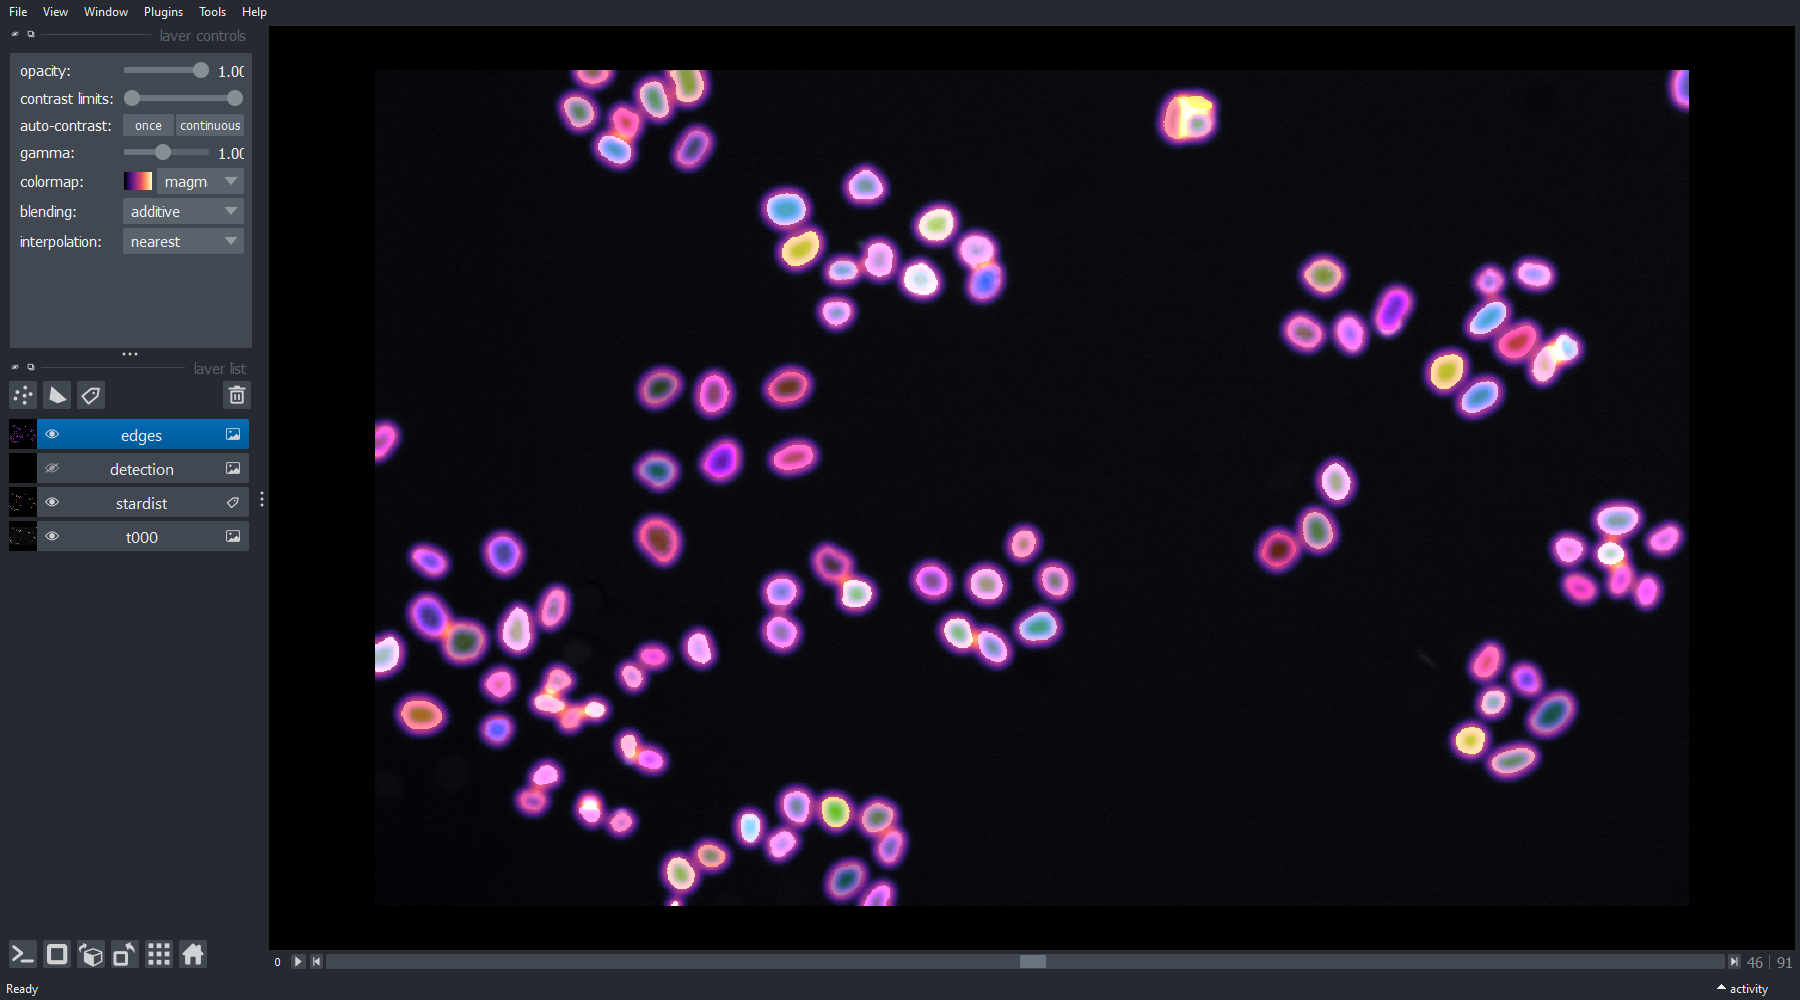

In [22]:
viewer.add_image(detection, visible=False)
viewer.add_image(edges, blending="additive", colormap="magma")
nbscreenshot(viewer)

In [23]:
config = MainConfig()
pprint(config)

MainConfig(
│   data_config=DataConfig(working_dir=WindowsPath('.'), database='sqlite', address=None, n_workers=1),
│   segmentation_config=SegmentationConfig(
│   │   threshold=0.5,
│   │   min_area=100,
│   │   max_area=1000000,
│   │   min_frontier=0.0,
│   │   anisotropy_penalization=0.0,
│   │   max_noise=0.0,
│   │   ws_hierarchy=<function watershed_hierarchy_by_area at 0x000001E7D7461CF0>,
│   │   n_workers=1
│   ),
│   linking_config=LinkingConfig(n_workers=1, max_neighbors=10, max_distance=15.0, distance_weight=0.0),
│   tracking_config=TrackingConfig(
│   │   appear_weight=-0.001,
│   │   disappear_weight=-0.001,
│   │   division_weight=-0.001,
│   │   dismiss_weight_guess=None,
│   │   include_weight_guess=None,
│   │   window_size=None,
│   │   overlap_size=1,
│   │   solution_gap=0.001,
│   │   time_limit=36000,
│   │   method=0,
│   │   n_threads=0,
│   │   link_function='power',
│   │   power=4,
│   │   bias=-0.0
│   )
)

Estimating params.: 100%|██████████| 92/92 [00:01<00:00, 65.81it/s]


<Axes: title={'center': 'Area histogram'}, ylabel='Frequency'>

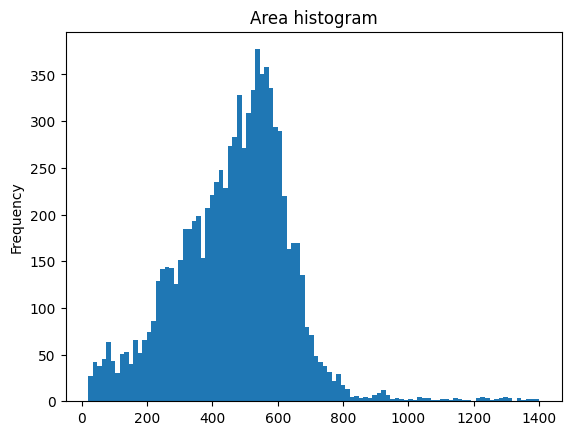

In [24]:
params_df = estimate_parameters_from_labels(stardist_labels, is_timelapse=True)
params_df["area"].plot(kind="hist", bins=100, title="Area histogram")

## Use hist plot to guard against outliers

In [25]:
config.segmentation_config.min_area = 50
config.segmentation_config.max_area = 950
config.segmentation_config.n_workers = 8

The remaining parameters are harder to estimate without ground-truth data, hence they were tuned by trial and error. From our experience setting the power parameter to 3 or 4 yields better results, specially in challenging scenarios. Note that, you must adjust the other *_weight accordingly when power is updated.

In [26]:
config.linking_config.max_distance = 25
config.linking_config.n_workers = 8

config.tracking_config.appear_weight = -1
config.tracking_config.disappear_weight = -1
config.tracking_config.division_weight = -0.1
config.tracking_config.power = 4
config.tracking_config.bias = -0.001
config.tracking_config.solution_gap = 0.0

pprint(config)


MainConfig(
│   data_config=DataConfig(working_dir=WindowsPath('.'), database='sqlite', address=None, n_workers=1),
│   segmentation_config=SegmentationConfig(
│   │   threshold=0.5,
│   │   min_area=50,
│   │   max_area=950,
│   │   min_frontier=0.0,
│   │   anisotropy_penalization=0.0,
│   │   max_noise=0.0,
│   │   ws_hierarchy=<function watershed_hierarchy_by_area at 0x000001E7D7461CF0>,
│   │   n_workers=8
│   ),
│   linking_config=LinkingConfig(n_workers=8, max_neighbors=10, max_distance=25, distance_weight=0.0),
│   tracking_config=TrackingConfig(
│   │   appear_weight=-1,
│   │   disappear_weight=-1,
│   │   division_weight=-0.1,
│   │   dismiss_weight_guess=None,
│   │   include_weight_guess=None,
│   │   window_size=None,
│   │   overlap_size=1,
│   │   solution_gap=0.0,
│   │   time_limit=36000,
│   │   method=0,
│   │   n_threads=0,
│   │   link_function='power',
│   │   power=4,
│   │   bias=-0.001
│   )
)

Now, we only need to execute the segment, link, and track functions and provide data_config and their respective configuration file.

In [27]:
segment(
    detection=detection,
    edge=edges,
    segmentation_config=config.segmentation_config,
    data_config=config.data_config,
    overwrite=True,
)

Adding nodes to database: 100%|██████████| 92/92 [00:35<00:00,  2.59it/s]


In [28]:
link(linking_config=config.linking_config, data_config=config.data_config, overwrite=True)

Linking nodes.: 100%|██████████| 91/91 [00:10<00:00,  8.43it/s]


In [29]:
solve(tracking_config=config.tracking_config, data_config=config.data_config, overwrite=True)

In [30]:
tracks_df, graph = to_tracks_layer(config.data_config)
labels = tracks_to_zarr(config.data_config, tracks_df)

typeddict.py (38): unsafe cast from int64 to int32. Precision may be lost.
Exporting segmentation masks: 100%|██████████| 92/92 [00:01<00:00, 70.44it/s]


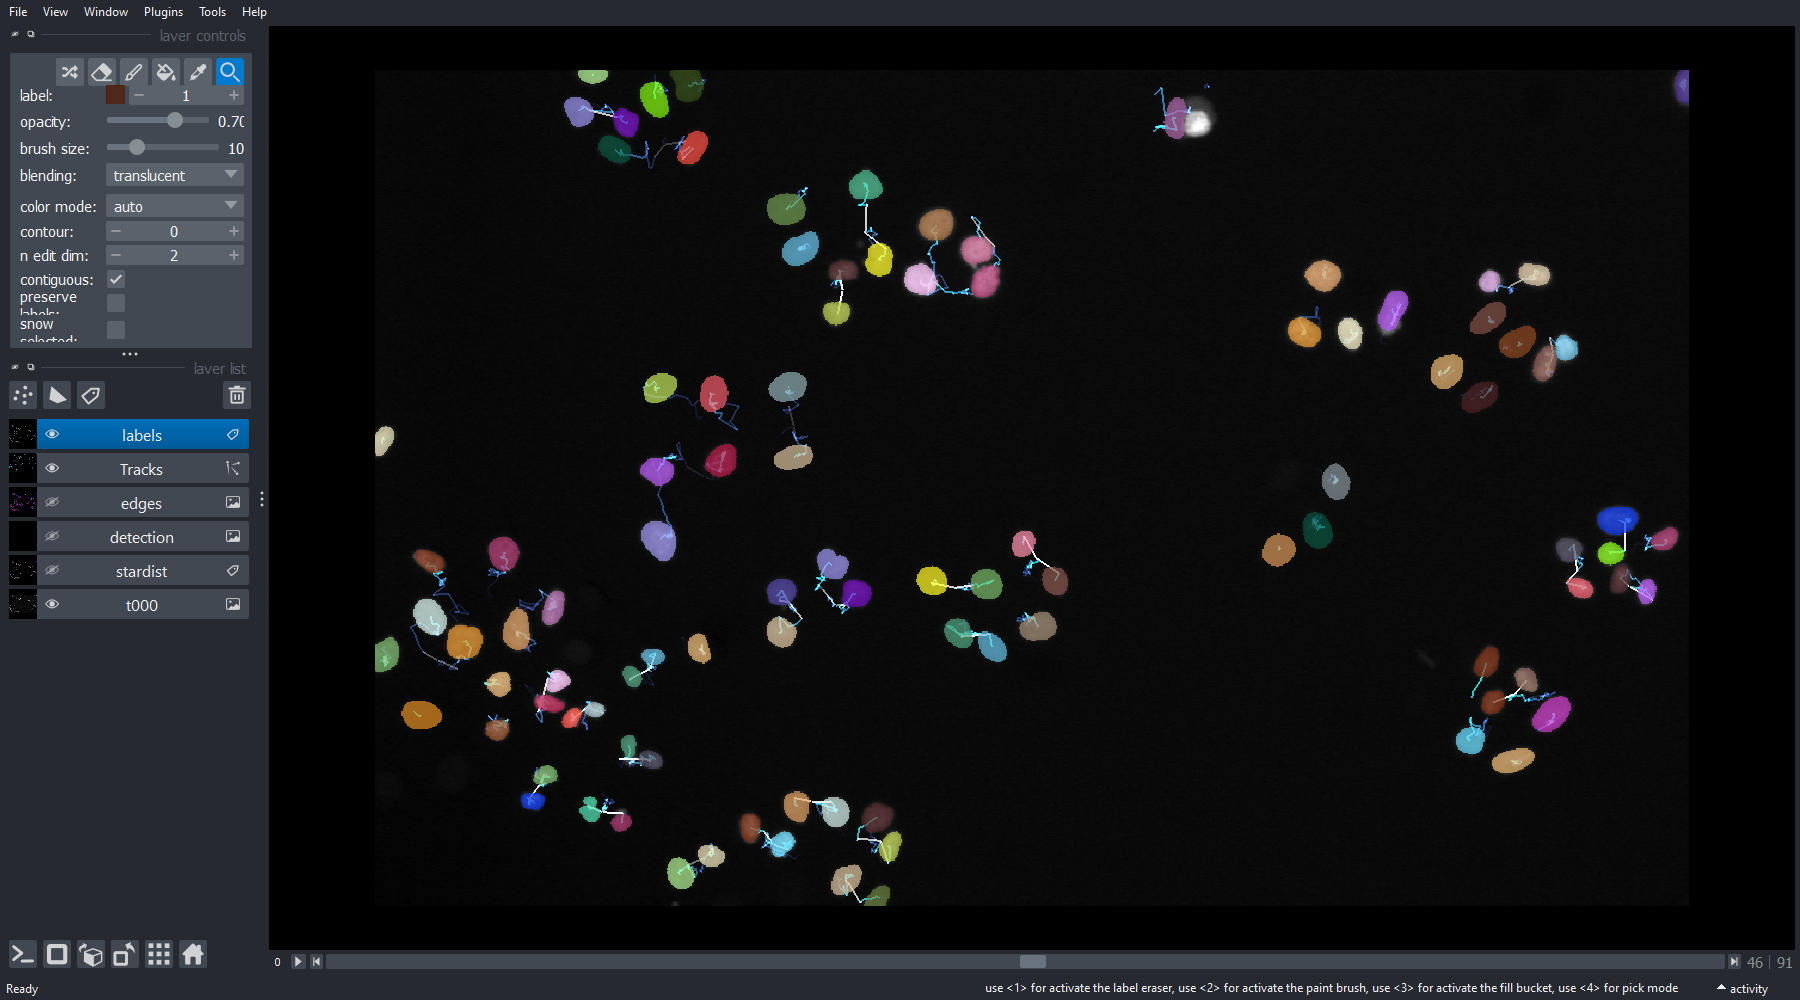

In [31]:
viewer.add_tracks(tracks_df[["track_id", "t", "y", "x"]].values, graph=graph)
viewer.add_labels(labels)

viewer.layers["stardist"].visible = False
viewer.layers["edges"].visible = False

nbscreenshot(viewer)